# **Róbert Šafár** & **Matúš Totcimak**
## The Quest: Q2 - **Household Electric Power Consumption**
#### Podiel práce 50:50
#
#

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller

from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

pd.set_option('display.max_columns', None)

#
# **4.1 EDA and data preprocessing**

### Načítanie .txt súboru

In [2]:
dff = pd.read_table("quest_data/power_consumption.txt",sep=';', dtype=str, low_memory=False)

#
## *A) EDA a data preprocessing pre Vami vybrané charakteristiky z datasetu*

### Názvy atribútov

In [3]:
dff.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

### Počet záznamov

In [4]:
dff.shape

(2075259, 9)

### Prvý pohľad na dáta

In [5]:
dff.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000


### Zíkladné info o datasete

In [6]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Date                   object
 1   Time                   object
 2   Global_active_power    object
 3   Global_reactive_power  object
 4   Voltage                object
 5   Global_intensity       object
 6   Sub_metering_1         object
 7   Sub_metering_2         object
 8   Sub_metering_3         object
dtypes: object(9)
memory usage: 142.5+ MB


In [7]:
dff.describe(include='all')

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2049280
unique,1442,1440,4187,533,2838,222,89,82,32
top,6/12/2008,17:24:00,?,0.000,?,1.000,0.000,0.000,0.000
freq,1440,1442,25979,481561,25979,172785,1880175,1436830,852092


### Po bližšom preskúmaní sme zistili, že niektoré záznamy ako hodnotu majú: `?`. Pre každý atribút zistíme, koľko `?` obsahuje.

In [8]:
for col in dff.columns:
    count = dff[col].str.contains(r'\?', na=False).sum()
    print(f"{col:<22}: {count}")

print(f"\n{'Columns 3-8':<22}: {dff[dff.columns[2:-1]].apply(lambda col: col.str.contains(r'\?', na=False)).all(axis=1).sum()}")

Date                  : 0
Time                  : 0
Global_active_power   : 25979
Global_reactive_power : 25979
Voltage               : 25979
Global_intensity      : 25979
Sub_metering_1        : 25979
Sub_metering_2        : 25979
Sub_metering_3        : 0

Columns 3-8           : 25979


#### Atribúty 3 až 8 obsahujú rovnaký počet `?`. Overili sme, že ak záznam obsahuje v ktoromkoľvek atribúte hodnotu: `?`, tak potom všetky dalšie atribúty (3 až 8) takisto obsahujú `?` v danom zázname.

### Keďže záznamy iba s `?` nemajú žiadnu hodnotu, tak ich vymažeme.

In [9]:
df = dff[~dff.apply(lambda col: col.map(lambda x: '?' in str(x))).any(axis=1)].copy()

### Overíme duplicitné záznamy.

In [10]:
df.duplicated().sum()

0

### Overíme chýbajúce hodnoty.

In [11]:
df.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### Atribúty `Date` a `Time` spojíme do nového atribútu `DateTime` a pretypujeme na `datetime64`.

In [12]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

### `DateTime` presunieme na začiatok; `Date` a `Time` môžeme vymazať.

In [13]:
df.insert(0, 'DateTime', df.pop('DateTime'))
df.drop(columns=['Date', 'Time'], inplace=True)

### Keďže pracujeme s číselnými hodnotami, tak pretypujeme atribúty na zodpovedajúce typy: `float` a `int`.

In [14]:
for column in df.columns[1:-3]:
    df[column] = pd.to_numeric(df[column], errors="coerce").astype(float)

for column in df.columns[-3:]:
    df[column] = pd.to_numeric(df[column], errors="coerce").astype(int)

### Zobrazíme korelácie atribútov na `Heat-Map` pre porovnanie. 

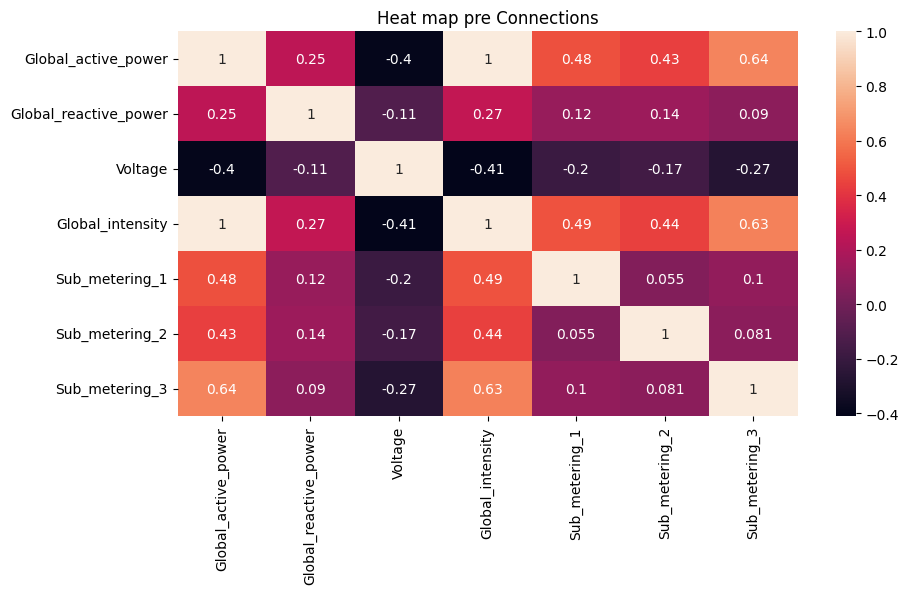

In [15]:
df_corr=df.iloc[:, 1:].corr()

fig, ax = plt.subplots(figsize=(10,5))

ax.set_title('Heat map pre Connections', fontsize=12)

sns.heatmap(df_corr, annot=True)
plt.show()

#### Môžeme napr. vidieť "perfektný lineárny" vzťah medzi `Global_active_power` a `Global_reactive_power`.
#

### Zoradíme záznamy podľa času merania (už teraz vyzerajú byť zoradené), aby sme mali istotu.

In [16]:
df.sort_values(by='DateTime', inplace=True)

#
#### `Funkcia:` Zobrazenie info o záznamoch a dátumoch.

In [17]:
def show_stats(dataframe):
    min_dates_per_year = dataframe.groupby(dataframe['DateTime'].dt.year)['DateTime'].min()
    max_dates_per_year = dataframe.groupby(dataframe['DateTime'].dt.year)['DateTime'].max()

    print(f"{'Rok':<6} {'Od':<12} {'Do':<12} {'v DF':<6} {'Má byť':<8} {'Rozdiel'}")
    print("-" * 60)

    should = [16, 365, 366, 365, 330]

    for (year, count), real_count in zip(dataframe.groupby(dataframe['DateTime'].dt.year).size().items(), should):
        min_date = min_dates_per_year[year]
        max_date = max_dates_per_year[year]
        
        print(f'{year:<6} {min_date.strftime("%Y-%m-%d"):<12} {max_date.strftime("%Y-%m-%d"):<12} {count:<6} {real_count:<8} {real_count - count}')

#### `Funkcia:` Zobrazenie chýbajúcich dátumov.

In [18]:
def show_missing_dates(dataframe):
    copied = dataframe.copy()
    copied = copied.set_index('DateTime')
    
    start_date = copied.index.min()
    end_date = copied.index.max()

    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    existing_dates = copied.index
    missing_dates = all_dates.difference(existing_dates)

    missing_dates_by_year = missing_dates.to_series().groupby(missing_dates.year).apply(list)

    for year, dates in missing_dates_by_year.items():
        print(f"\n{year}\n⁻⁻⁻⁻⁻⁻⁻")
        for date in dates:
            print(f"  {date.date()}")

#
### Vieme už, že nemáme záznamy pre kompletne celé roky. Chceme však zistiť, či máme merania pre každý deň od `12/2006` až `11/2010`.

In [19]:
df_including = df.resample('D', on='DateTime').mean().reset_index()
show_stats(dataframe=df_including)

Rok    Od           Do           v DF   Má byť   Rozdiel
------------------------------------------------------------
2006   2006-12-16   2006-12-31   16     16       0
2007   2007-01-01   2007-12-31   365    365      0
2008   2008-01-01   2008-12-31   366    366      0
2009   2009-01-01   2009-12-31   365    365      0
2010   2010-01-01   2010-11-26   330    330      0


In [20]:
show_missing_dates(dataframe=df_including)

In [21]:
df_including.isna().sum()

DateTime                 0
Global_active_power      9
Global_reactive_power    9
Voltage                  9
Global_intensity         9
Sub_metering_1           9
Sub_metering_2           9
Sub_metering_3           9
dtype: int64

#### Napriek tomu, že sa počty dni zhodujú a žiadne chýbajúce dni sa nevypísali, ak overíme `Na` hodnoty, tak ich máme 9 v každom atribúte.
### Vypíšeme záznamy s `Na` hodnotami.

In [22]:
df_including[df_including.isna().any(axis=1)]

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
134,2007-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
911,2009-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1124,2010-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341,2010-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1342,2010-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1343,2010-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1344,2010-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1380,2010-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1381,2010-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Vidíme, že záznamov je 9 a všetky atribúty okrem `DateTime` sú `Na`. Znamená to, že pre týchto 9 dní nemáme žiadne zaznamenané merania.
#
### Ak pre porovnanie budeme brať do úvahy iba dni, ktoré majú aspoň jedno zaznamenané meranie tak:

In [23]:
df_excluding = df.groupby(df['DateTime'].dt.date, as_index=False).mean()
df_excluding['DateTime'] = pd.to_datetime(df_excluding['DateTime']).dt.normalize()
show_stats(dataframe=df_excluding)

Rok    Od           Do           v DF   Má byť   Rozdiel
------------------------------------------------------------
2006   2006-12-16   2006-12-31   16     16       0
2007   2007-01-01   2007-12-31   364    365      1
2008   2008-01-01   2008-12-31   366    366      0
2009   2009-01-01   2009-12-31   364    365      1
2010   2010-01-01   2010-11-26   323    330      7


In [24]:
show_missing_dates(dataframe=df_excluding)


2007
⁻⁻⁻⁻⁻⁻⁻
  2007-04-29

2009
⁻⁻⁻⁻⁻⁻⁻
  2009-06-14

2010
⁻⁻⁻⁻⁻⁻⁻
  2010-01-13
  2010-08-18
  2010-08-19
  2010-08-20
  2010-08-21
  2010-09-26
  2010-09-27


In [25]:
df_excluding.isna().sum()

DateTime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

#### Vidíme, že získame tých istých 9 dní ako predtým.
#

### Počet meraní pre jednotlivé roky z datasetu.

In [26]:
for year, count in df.groupby(df['DateTime'].dt.year).size().items():
    print(f'{year} : {count:,}')

2006 : 21,992
2007 : 521,669
2008 : 526,905
2009 : 521,320
2010 : 457,394


#### Rok `2006` má výrazne menej meraní oproti ďalším rokom, pretože merania začali až v Decembri daného roku.

### Porovnanie celkových hodnôt atribútov podľa rokov.

In [27]:
df.resample('YE', on='DateTime').sum().astype(int)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-31,41813,2889,5309773,176594,27460,48712,162951
2007-12-31,582708,61225,124879155,2485492,642548,854360,3022840
2008-12-31,564893,61705,126787268,2398458,584784,661905,3179187
2009-12-31,562315,68505,126104354,2374625,592657,592145,3556816
2010-12-31,485295,59199,110467752,2048404,451686,503909,3313373


#
#### `Funkcia:` Zobrazenie priemernej `Global_active_power` za dané obdobie.

In [28]:
def show_power_graph(df, by):
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(15, 7))
    sns.lineplot(data=df, x='DateTime', y='Global_active_power', color='#10375C')

    plt.title(f'Priemerná {by}spotreba energie počas obdobia 12/2006 - 10/2010', fontsize=16)
    plt.xlabel('Obdobie', fontsize=12)
    plt.ylabel('Priemerná spotreba energie', fontsize=12)
    plt.xticks()
    plt.tight_layout()
    plt.show()

### Priemerná spotreba `Global_active_power` každú minútu.

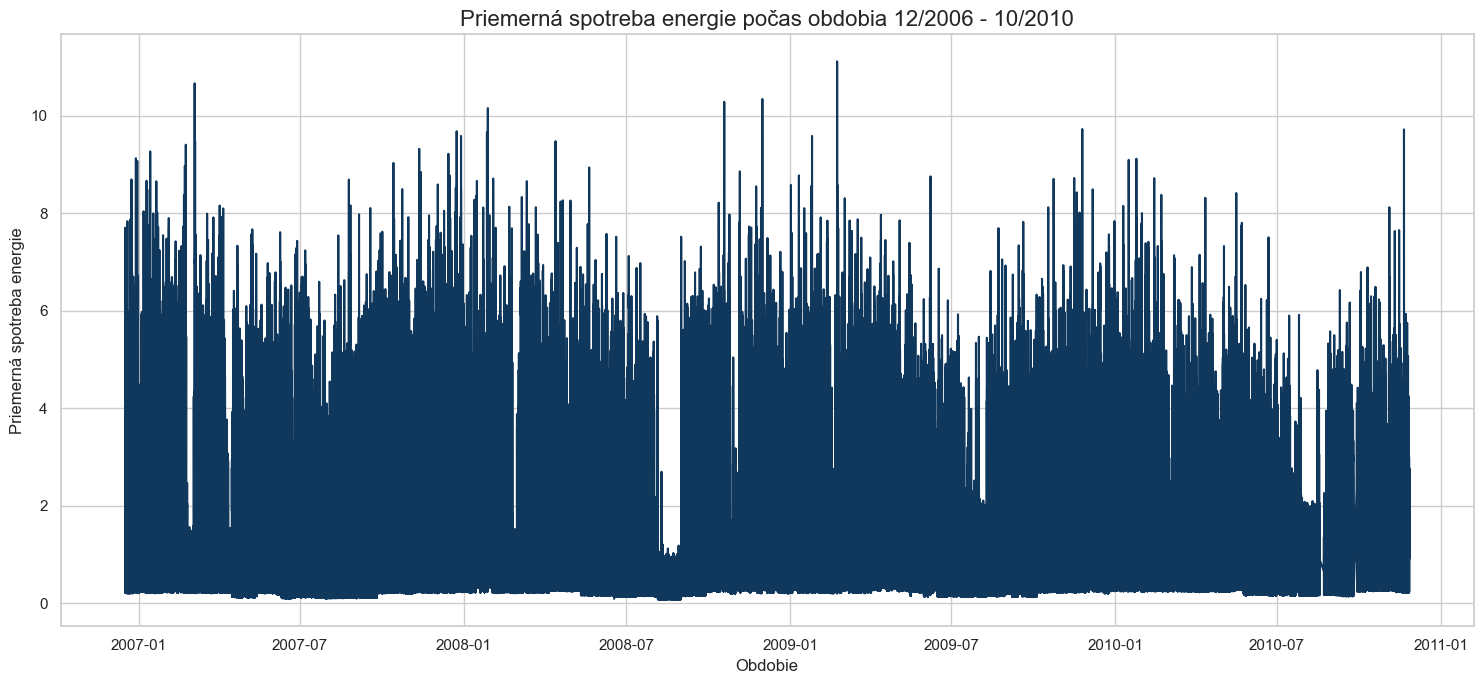

In [29]:
show_power_graph(df=df, by="")

### Priemerná spotreba `Global_active_power` každý deň.

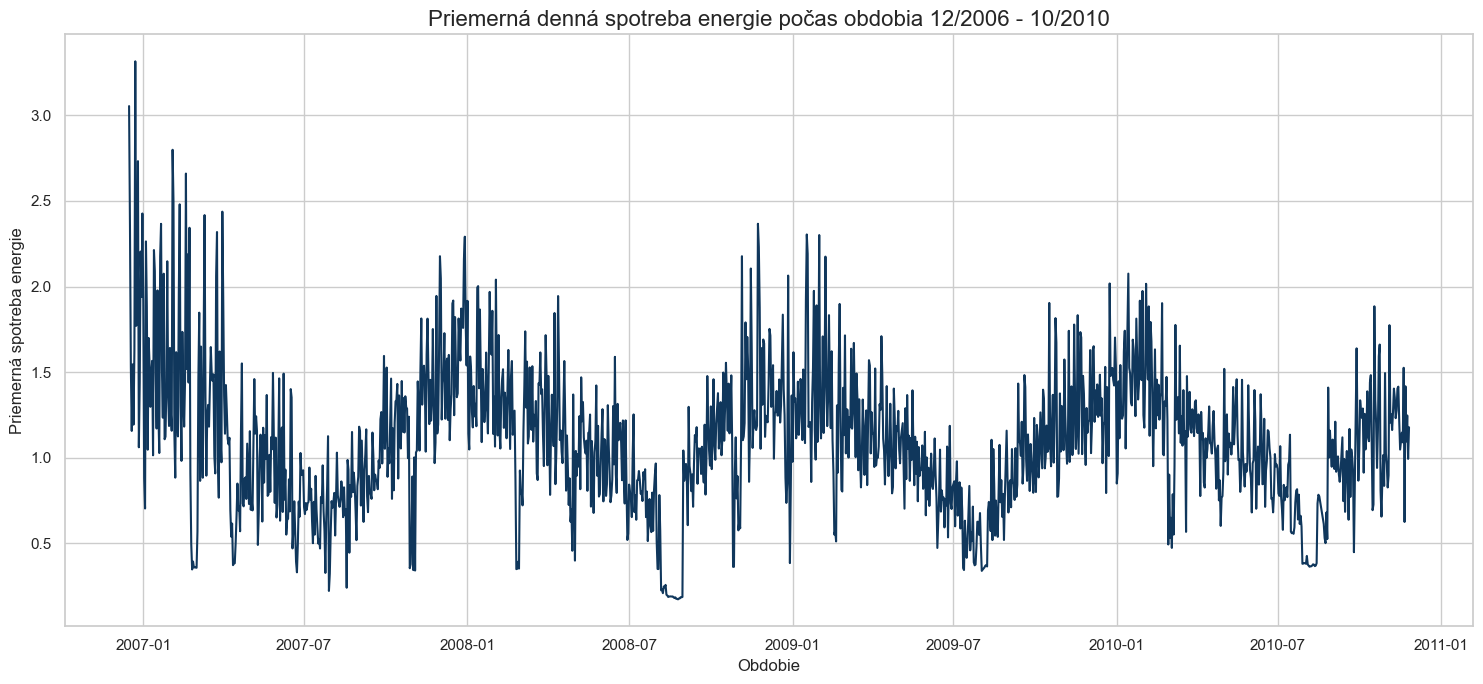

In [30]:
df_day = df.resample('D', on='DateTime').mean().reset_index()
show_power_graph(df=df_day, by="denná ")

#### Z grafu môžeme vidieť, že približne od `Júla` do `Júla` sa opakuje akýsi vzor.
#

### Porovnanie priemerných `Global_active_power` pre jednotlivé roky.

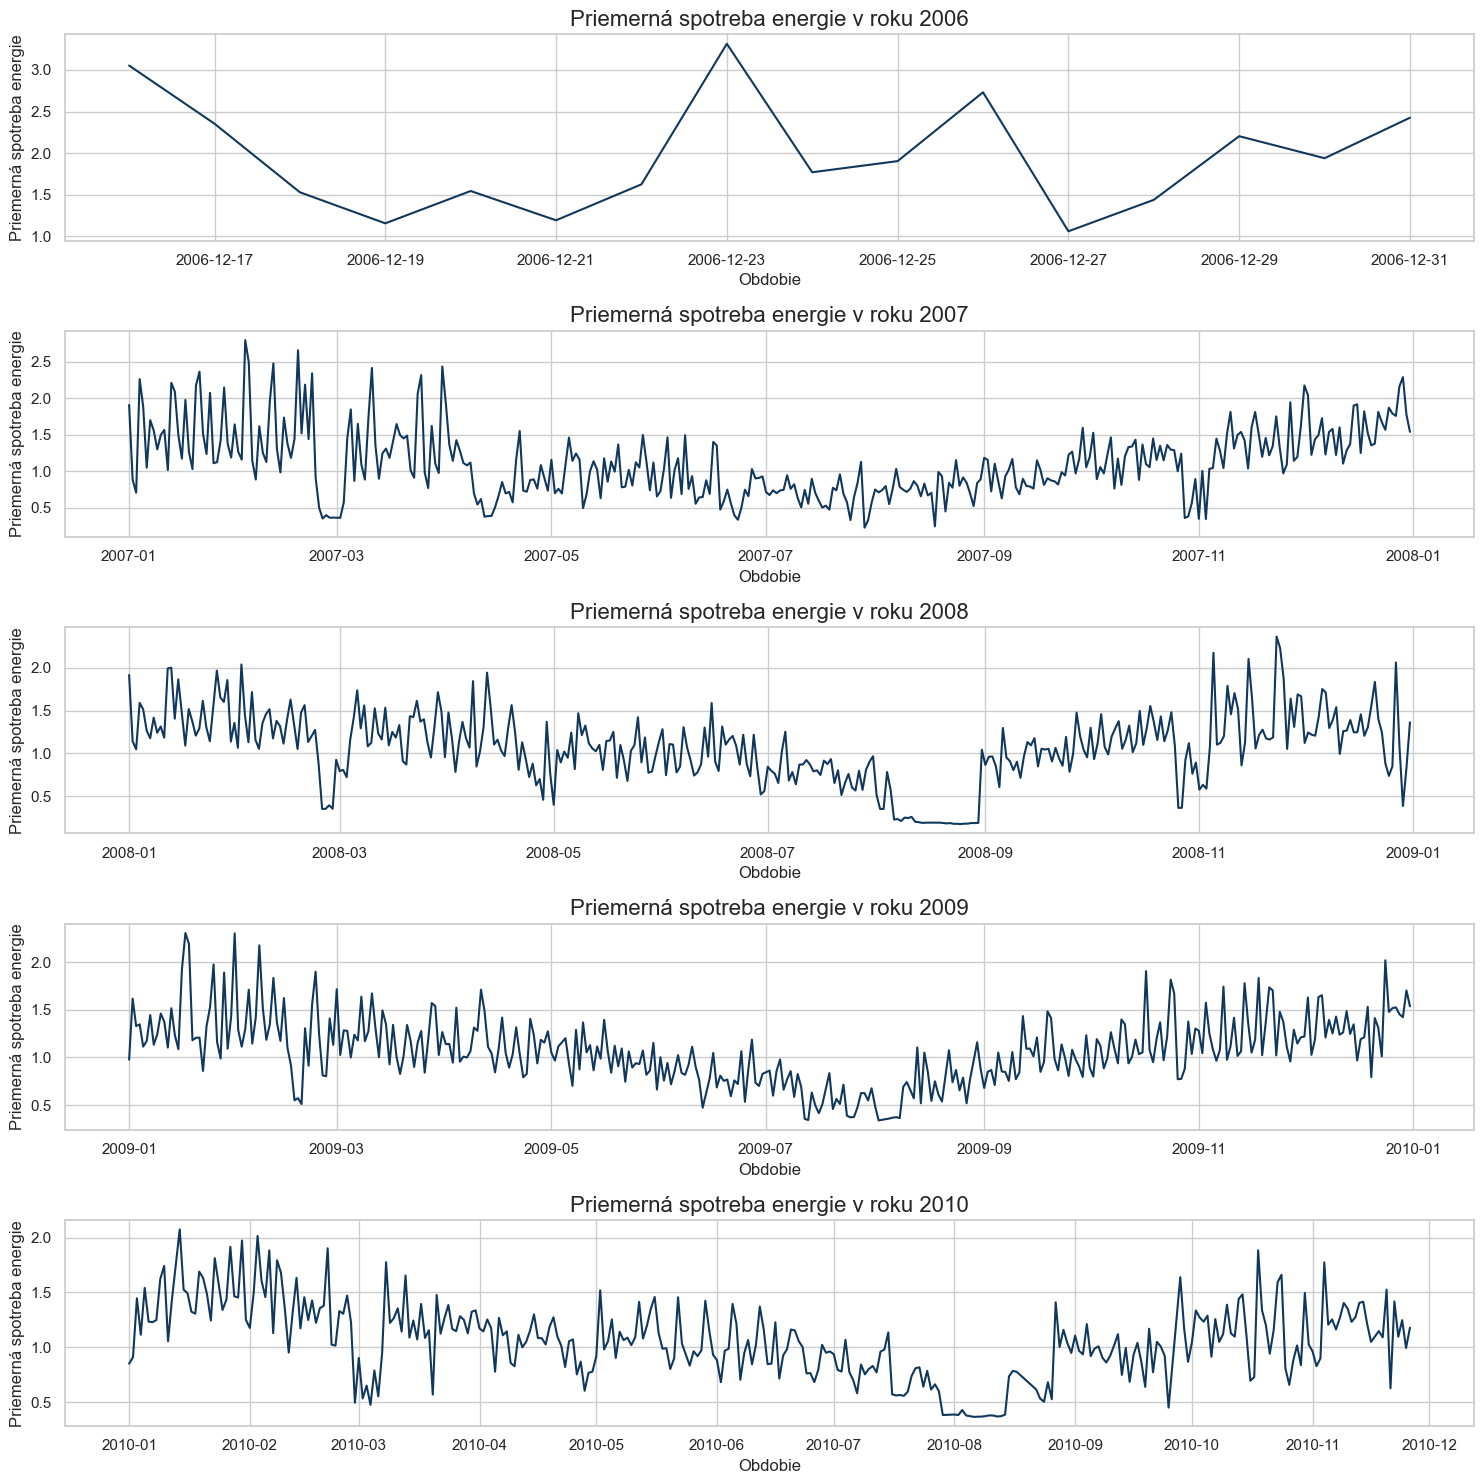

In [31]:
def show_power_graph(df):
    sns.set_theme(style="whitegrid")

    years = [2006, 2007, 2008, 2009, 2010]

    fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(15, 3 * len(years)))
    
    if len(years) == 1:
        axes = [axes]
    
    for i, year in enumerate(years):
        df_year = df[df['DateTime'].dt.year == year]

        sns.lineplot(data=df_year, x='DateTime', y='Global_active_power', color='#10375C', ax=axes[i])
        
        axes[i].set_title(f'Priemerná spotreba energie v roku {year}', fontsize=16)
        axes[i].set_xlabel('Obdobie', fontsize=12)
        axes[i].set_ylabel('Priemerná spotreba energie', fontsize=12)

    plt.tight_layout()
    plt.show()

show_power_graph(df_day)

#### Výsledky pre rok `2006` môžeme zanedbať, pretože obsahuje výrazne menej meraní oproti ďalšim rokom. V rokoch `2008`, `2009` a `2010` môžeme vidieť, že v mesiaci `August` je akési potencionálne "minimum", ktoré môže niečo naznačovať.
#

#### `Funkcia:` Porovanie 2 atribútov za jednotlivé roky na `bar-plote`.

In [32]:
def attributes_comparison(attr1, type1, attr2, type2):
    df_comparison = df.resample('YE', on='DateTime')[[attr1, attr2]].sum()

    active_color = '#10375C'
    reactive_color = '#EB8317'
    width = 0.35
    x = df_comparison.index.year

    plt.figure(figsize=(14, 7))

    plt.bar(x - width / 2, df_comparison[attr1], width=width, color=active_color, label=f'{attr1} ({type1})')
    plt.bar(x + width / 2, df_comparison[attr2], width=width, color=reactive_color, label=f'{attr2} ({type2})')

    for i, (active, reactive) in enumerate(zip(df_comparison[attr1], df_comparison[attr2])):
        plt.text(x[i] - width / 2, active + 0.1, f'{active:,.0f}', ha='center', va='bottom', fontsize=10, color=active_color)
        plt.text(x[i] + width / 2, reactive + 0.1, f'{reactive:,.0f}', ha='center', va='bottom', fontsize=10, color=reactive_color)

    plt.title(f'Porovnanie súčtov ({attr1} a {attr2}) podľa rokov', fontsize=16)
    plt.xlabel('Rok', fontsize=12)
    plt.ylabel('Rozsah', fontsize=12)
    plt.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()

#
### Porovnanie `Global_active_power` a `Global_reactive_power` pre jednotlivé roky.

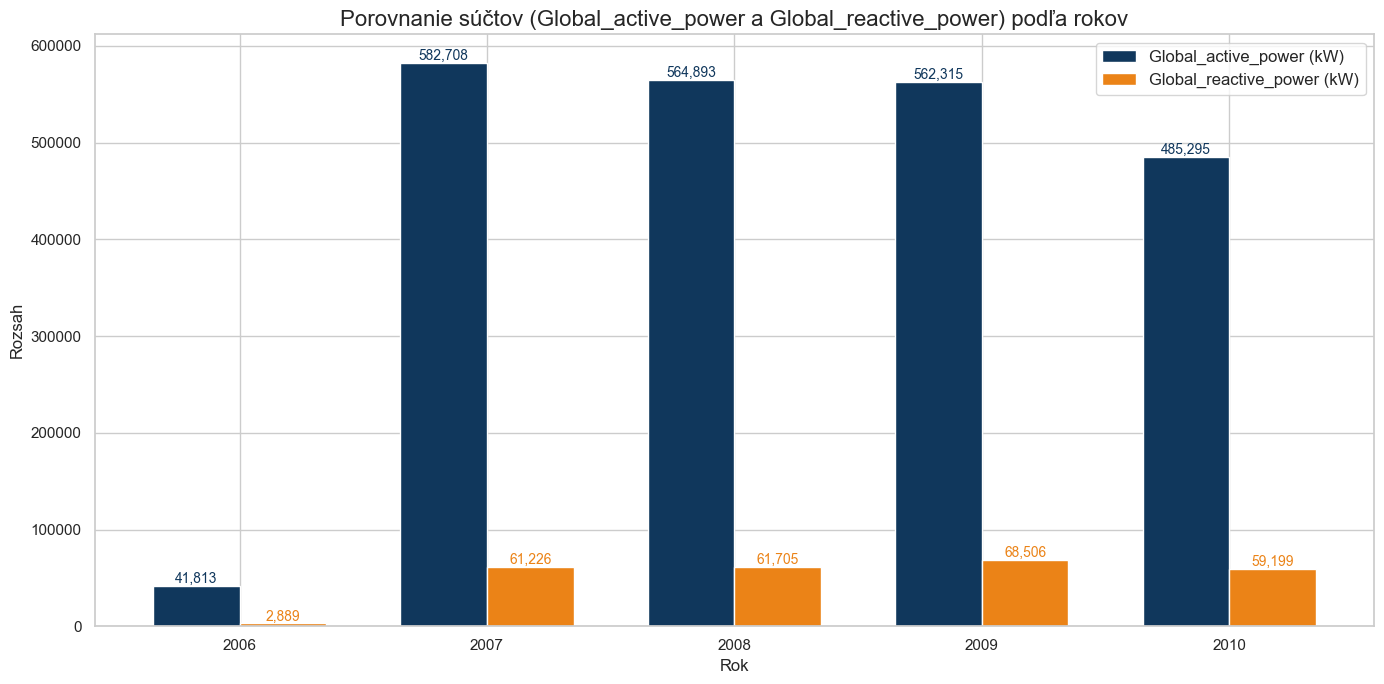

In [33]:
attributes_comparison(attr1='Global_active_power', type1='kW', attr2='Global_reactive_power', type2='kW')

#
### Porovnanie `Sub_metering_1` a `Sub_metering_2` pre jednotlivé roky.

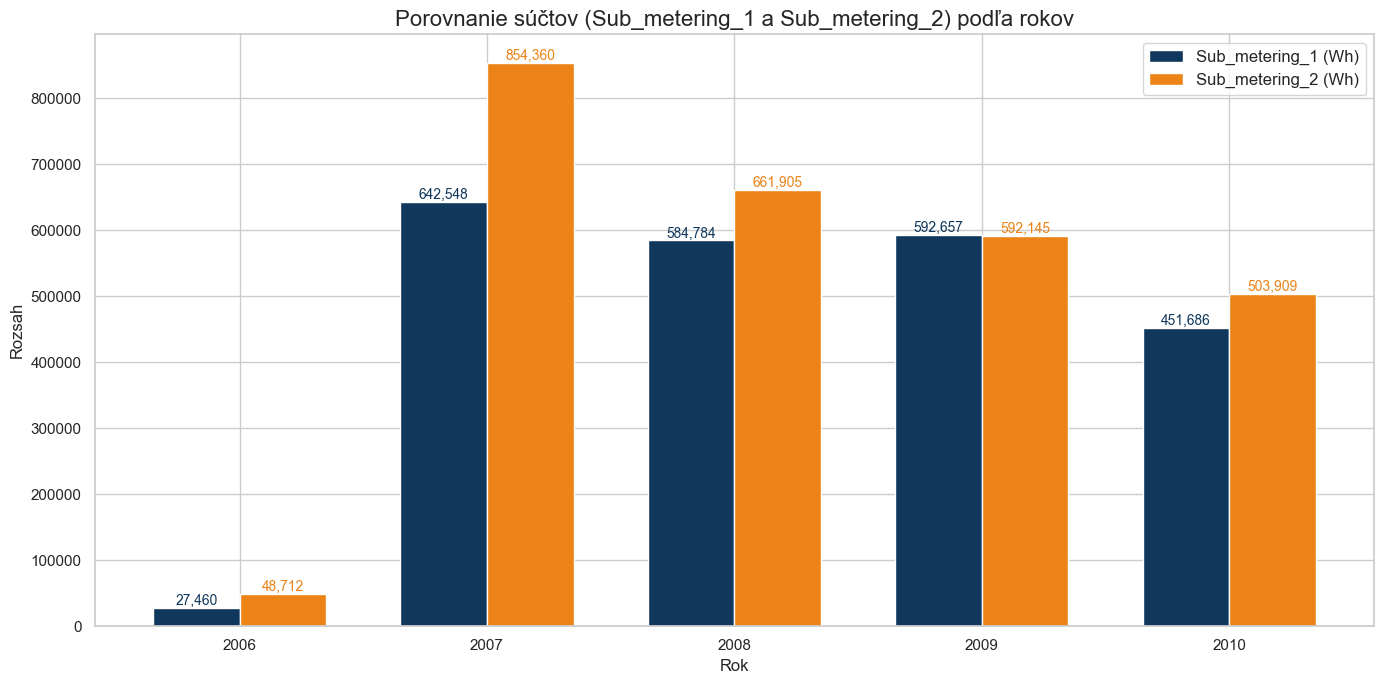

In [34]:
attributes_comparison(attr1='Sub_metering_1', type1='Wh', attr2='Sub_metering_2', type2='Wh')

### Doplníme hodnoty pre 9 chýbajúcich dní cez `interpoláciu`.

In [35]:
df_day_all = df_day.interpolate(method='linear')

### Overenie hodnôt chýbajúcích dní.

In [36]:
missing_indexes = [134, 911, 1124, 1341, 1342, 1343, 1344, 1380, 1381]
df_day_all.loc[missing_indexes]

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
134,2007-04-29,0.906678,0.130350,234.428113,3.938666,1.053819,0.862599,0.981771
911,2009-06-14,0.628798,0.143385,242.267049,2.695008,0.464975,0.259983,4.190778
1124,2010-01-13,1.755838,0.191979,243.917792,7.329405,3.480211,2.094467,8.533957
1341,2010-08-18,0.742910,0.120137,241.326658,3.175484,0.595880,0.540783,3.873659
1342,2010-08-19,0.710699,0.130643,241.661145,3.058258,0.446910,0.494403,3.398665
1343,2010-08-20,0.678488,0.141148,241.995632,2.941031,0.297940,0.448023,2.923672
1344,2010-08-21,0.646277,0.151653,242.330118,2.823805,0.148970,0.401643,2.448678
1380,2010-09-26,0.845824,0.110588,240.598633,3.579004,1.096400,0.633949,3.578692
1381,2010-09-27,1.242469,0.100311,240.422139,5.215634,2.192799,0.632306,3.360775


#
## *B) Zdôvodnite výber ML/DL metód vzhľadom na Vami vybraný dataset pre 4.2*

### Rozhodli sme sa použiť `ARIMA` model, na vyskúšanie. Hlavnými modelmi v časti `4.2` však budú modely `RNN`, nakoľko si uchovaváva predošlé hodnoty a je dobrý pre 'time-series' prediction, nakoľko je schopný rozpoznávať vzory v dátach.

#
# **4.2 Modeling and evaluation**

#
## *A) Modeluje Vami tie vybrané charakteristiky pomocou vhodných ML/DL metód. Výsledok modelovania je najlepší model*

## **ARIMA**

### Zvolíme `Global_active_power` ako predikovaný atribút.

In [37]:
gap = df_day_all['Global_active_power']
x_axis = df_day_all['DateTime']

### Rozdelenie dát na `train` a `test`, kde `train` je prvých 80% a `test` posledných 20%.

In [38]:
train = gap.iloc[:int(len(gap) * 0.8)]
test = gap.iloc[int(len(gap) * 0.8):]

### Overenie stacionarity cez `Augmented Dickey-Fuller test`.

In [39]:
result = adfuller(gap)
print('ADF Test Statistic:', result[0])
print('p-hodnota:', result[1])
print('Kritické hodnoty:', result[4])

if result[1] <= 0.05:
    print("Dáta sú stacionárne")
else:
    print("Dáta nie sú stacionárne")

ADF Test Statistic: -3.6656968507088292
p-hodnota: 0.00462236366627469
Kritické hodnoty: {'1%': -3.434966750462565, '5%': -2.8635789736973725, '10%': -2.5678555388041384}
Dáta sú stacionárne


#### Na základe výsledkov môžeme použiť `ARIMA` model bez potreby diferenciácie.

#
### Zobrazenie `ACF` a `PACF` grafov.

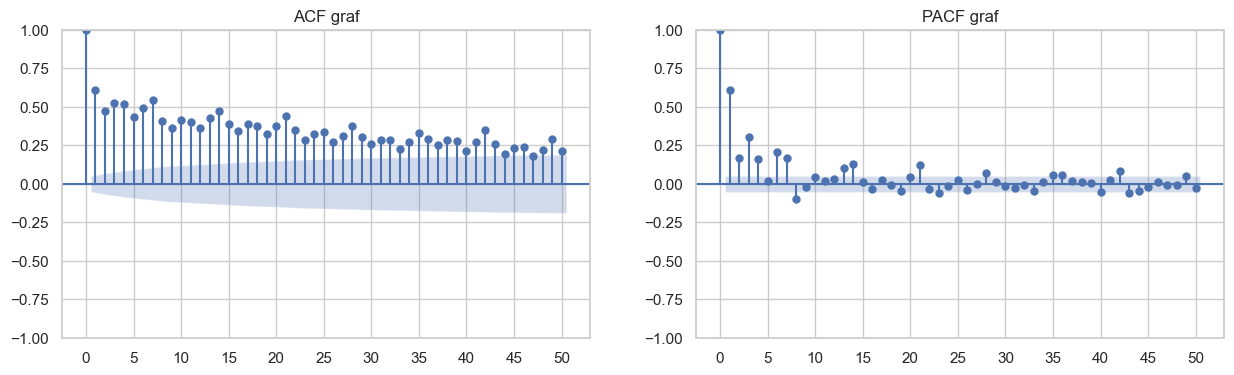

In [40]:
plt.figure(figsize=(15, 4))

# ACF
plt.subplot(121)
plot_acf(gap, lags=50, ax=plt.gca())
plt.xticks(ticks=range(0, 51, 5))
plt.title('ACF graf')

# PACF
plt.subplot(122)
plot_pacf(gap, lags=50, ax=plt.gca(), method='ywm')
plt.xticks(ticks=range(0, 51, 5))
plt.title('PACF graf')

plt.show()

#### Z `ACF` grafu vyčítame hodnotu signifikantnosti: 23 a z `PACF` grafu hodnotu: 7.
#

#### `Funkcia:` Vykreslenie výsledkov predikcie.

In [41]:
def plot_forecasts(train, test, forecasts, x_axis, title):
    fig = go.Figure()

    # TRAIN
    fig.add_trace(go.Scatter(x=x_axis[:len(train)], y=train, 
                             mode='lines', name='Train', line=dict(color='blue')))
    
    # TEST
    fig.add_trace(go.Scatter(x=x_axis[len(train):], y=test, 
                             mode='lines', name='Test', line=dict(color='orange')))
    
    # FORECAST
    fig.add_trace(go.Scatter(x=x_axis[len(train):], y=forecasts, 
                             mode='lines', name='Forecast', line=dict(color='green')))
    
    fig.update_layout(
        template="simple_white",
        font=dict(size=16),
        title_text=title,
        title_x=0.5,
        xaxis_title='DateTime',
        yaxis_title='Global Active Power',
        width=1150,
        height=500
    )
    
    fig.show()

#
### Volanie `ARIMA` modelu a zobrazenie predikcie.

In [70]:
X_selected = df_day_all[['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

arima_model = ARIMA(endog=train, exog=X_selected[:len(train)], order=(23,0,7)).fit() 
forecast = arima_model.forecast(steps=len(test), exog=X_selected[len(train):]) 

plot_forecasts(train, test, forecast, x_axis, "ARIMA Predikcia")

#### Vidíme, že `Forecast` sa totálne zhoduje s `Test`. Túto dokonalú predikciu podľa nás veľmi ovplyvňuje použitie `exogénnych` premenných v modeli. Bez ich použitia je predikcia nepoužiteľná, pretože výsledkom je len rovná čiara.
#

### `ARIMA` predikcia bez exogénnych premenných.

In [71]:
arima_model_2 = ARIMA(endog=train, order=(23,0,7)).fit() 
forecast = arima_model_2.forecast(steps=len(test)) 

plot_forecasts(train, test, forecast, x_axis, "ARIMA Predikcia")

c:\Users\matus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



#
## **RNN**
### `Model 1`
#

### Výber predikovanej premennej `Global_active_power`.

In [43]:
data = df_day_all["Global_active_power"].values.reshape(-1,1)

### Použitie `MinMax` scaler na úpravu predikovannej premennej.

In [44]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

#### `Funkcia:` Vytvorenie sekvencií.

In [45]:
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

### Výber sekvencií na trénovanie a testovanie.

In [46]:
look_back = 30
X, y = create_sequences(scaled_data, look_back)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Premenná `look_back` hovorí koľko hodnôt dozadu bude model brať do úvahy pri predikovaní budúcnosti.
#

### Vytvorenie `modelu 1` so 4-mi vrstvami.

In [47]:
model_1 = Sequential([
    Input(shape = (X_train.shape[1], 1)),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model_1.compile(optimizer='adam', loss='mean_squared_error')

#### `Input` layer - pripraví dáta pre ďalšie vrstvy.
#### `LSTM` layer - zodpovedá za učenie sa vzorov v dátach.
#### `Dropout` layer - pomáha predchádzať overfittingu.
#### `Dense` layer - zodpovedná za output.
#

### Trénovanie `modelu 1`.

In [ ]:
model_1.fit(X_train, y_train, epochs=20, batch_size=1240, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1216 - val_loss: 0.1119
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1082 - val_loss: 0.0993
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0960 - val_loss: 0.0875
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0850 - val_loss: 0.0766
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0743 - val_loss: 0.0664
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0643 - val_loss: 0.0568
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0548 - val_loss: 0.0478
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0460 - val_loss: 0.0393
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0379 - val_loss: 0.0316
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0301 - val_loss: 0.0246
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0239 - val_loss: 0.0188
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0183 - val_loss:

### Model otestujeme na testovacích dátach, ktoré následne vyškálujeme do pôvodného stavu.

In [49]:
predicted = model_1.predict(X_test)
predicted = scaler.inverse_transform(predicted)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


### Rovnakým inverzným škálovaním získame pôvodné trénovacie a testovacie dáta.

In [50]:
train_actual = scaler.inverse_transform(y[:len(X_train)])
test_actual = scaler.inverse_transform(y[len(X_train):])

### Sumár `modelu 1`.

In [91]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

#
### `Model 2`
#

### Vytvorenie `modelu 2` s 3-mi vrstvami.

In [51]:
model_2 = Sequential([
    Input(shape = (X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])
model_2.compile(optimizer='adam', loss='mean_squared_error')

#### Pomocou `modelu 2` chceme zistiť vplyv `Dropout` vrstvy na predikciu. Preto celú túto vrstvu nepoužijeme v modeli.
#

### Trénovanie `modelu 2`.

In [ ]:
model_2.fit(X_train, y_train, epochs=20, batch_size=1240, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0877 - val_loss: 0.0767
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0739 - val_loss: 0.0640
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.0614 - val_loss: 0.0525
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0501 - val_loss: 0.0422
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0401 - val_loss: 0.0333
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0313 - val_loss: 0.0256
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0238 - val_loss: 0.0193
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0177 - val_loss: 0.0146
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0119
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0107 - val_loss: 0.0112
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0102 - val_loss: 0.0126
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0117 - val_loss:

### Model otestujeme na testovacích dátach, ktoré následne vyškálujeme do pôvodného stavu.

In [53]:
predicted2 = model_2.predict(X_test)
predicted2 = scaler.inverse_transform(predicted2)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


### Sumár `modelu 2`.

In [90]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

#
### `Model 3`
#

### Vytvorenie `modelu 3` s 5-mi vrstvami.

In [54]:
model_3 = Sequential([
    Input(shape = (X_train.shape[1], 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model_3.compile(optimizer='adam', loss='mean_squared_error')

#### Pomocou `modelu 3` chceme zistiť vplyv `LSTM` vrstvy na predikciu. Preto pridáme druhú vsrtvu.
#

### Trénovanie `modelu 3`.

In [ ]:
model_3.fit(X_train, y_train, epochs=20, batch_size=1240, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1027 - val_loss: 0.0784
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.0754 - val_loss: 0.0552
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.0535 - val_loss: 0.0362
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.0349 - val_loss: 0.0218
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.0217 - val_loss: 0.0130
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0133 - val_loss: 0.0115
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.0126 - val_loss: 0.0164
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.0179 - val_loss: 0.0208
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0233 - val_loss: 0.0206
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.0225 - val_loss: 0.0176
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.0190 - val_loss: 0.0143
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.0151 - val_loss:

#
### Model otestujeme na testovacích dátach, ktoré následne vyškálujeme do pôvodného stavu.

In [56]:
predicted3 = model_3.predict(X_test)
predicted3 = scaler.inverse_transform(predicted3)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


### Sumár `modelu 3`.

In [89]:
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

#
### Porovnanie predikovaných údajov jednotlivých modelov.

In [57]:
plot_forecasts(
    train=train_actual.flatten(),
    test=test_actual.flatten(),
    forecasts=predicted.flatten(),
    x_axis=x_axis,
    title="RNN model 1 predikcia"
)

In [58]:
plot_forecasts(
    train=train_actual.flatten(),
    test=test_actual.flatten(),
    forecasts=predicted2.flatten(),
    x_axis=x_axis,
    title="RNN model 2 predikcia"
)

In [59]:
plot_forecasts(
    train=train_actual.flatten(),
    test=test_actual.flatten(),
    forecasts=predicted3.flatten(),
    x_axis=x_axis,
    title="RNN model 3 predikcia"
)

#
#### `Funkcia:` Vypísanie metrík modelu.

In [81]:
metrics = ['Train Mean Absolute Error', 'Train Root Mean Squared Error', 'Test Mean Absolute Error', 'Test Root Mean Squared Error']
def print_metrics(train_predict, test_predict, y_train, y_test):
    data_list = [mean_absolute_error(y_train, train_predict),
                 np.sqrt(mean_squared_error(y_train, train_predict)),
                 mean_absolute_error(y_test, test_predict),
                 np.sqrt(mean_squared_error(y_test, test_predict))]
    
    for metric, value in zip(metrics, data_list):
        print(f"{metric:<29} : {value}")

#
### Metriky `modelu 1`.

In [82]:
train_predict = model_1.predict(X_train)
test_predict = model_1.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [83]:
print_metrics(train_predict=train_predict, test_predict=test_predict, y_train=y_train, y_test=y_test)

Train Mean Absolute Error     : 0.09384905421374329
Train Root Mean Squared Error : 0.11675551432172726
Test Mean Absolute Error      : 0.09714853723534819
Test Root Mean Squared Error  : 0.11914887043751678


#
### Metriky `modelu 2`.

In [84]:
train_predict2 = model_2.predict(X_train)
test_predict2 = model_2.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [85]:
print_metrics(train_predict=train_predict2, test_predict=test_predict2, y_train=y_train, y_test=y_test)

Train Mean Absolute Error     : 0.07703591901839725
Train Root Mean Squared Error : 0.10070631061973763
Test Mean Absolute Error      : 0.0822411971810216
Test Root Mean Squared Error  : 0.10618234870171435


#
### Metriky `modelu 3`.

In [86]:
train_predict3 = model_3.predict(X_train)
test_predict3 = model_3.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [87]:
print_metrics(train_predict=train_predict3, test_predict=test_predict3, y_train=y_train, y_test=y_test)

Train Mean Absolute Error     : 0.08609488087870153
Train Root Mean Squared Error : 0.11519171687337665
Test Mean Absolute Error      : 0.0898591005228285
Test Root Mean Squared Error  : 0.12069074289687047


#
### Po zhodnotení výsledkov je náš najlepší model: `model 2`.
### Dosahuje najnižšiu chybovosť naprieč všetkými modelmi vo všetkých metrikách.

#
## *B) Zhodnotíte Váš prístup a získaný výsledok*

### Ak `Model 1`, ktorý môžeme považovať za "base" model, porovnáme so zvyšnými dvoma, tak vieme povedať...
### Odstránenie vrstvy `Dropout(0.2)` v `Modeli 2` model zlepšilo. Konkrétne voči `Modelu 1` je error na trénovacích dátach menší o približne `0.016` a na testovacích menší o približne `0.014`. V porovnaní s `Modelom 3` je rozdiel o niečo vačší.
### Pridanie vrstvy `LSTM(50, return_sequences=True)` v `Modeli 3` model nezlepšilo.
### Ak sa pozrieme na grafy, tak pre modely `1 a 2` vyzerajú veľmi podobne. Viditeľné rozdiely sú však napr. na miestach kde dochádza k výraznym úpadkom. Tam `Model 2` lepšie kopíruje testovacie dáta ako `Model 1`.